# 🎓 **Taller 4.3: Taller de Métodos de clustering basados en particiones Parte 2**


## OBJETIVOS DEL TALLER:
En esta práctica estudiaremos el funcionamiento y la utilización métodos de clustering basados en particiones, como el K-means y el K-medoids.

# 🔧 **CONFIGURACIÓN INICIAL**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.rcParams['figure.figsize'] = [8, 8]

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [2]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

✅ Dataset cargado desde URL GitHub


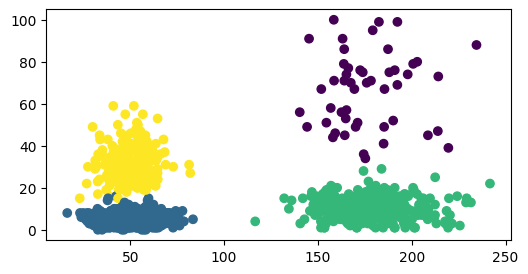

In [3]:
# Cargar dataset
D =cargar_dataset("dataset_cuatro_diferente_densidad.xlsx")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

# 🎯 **:Cree el algoritmo K-means que tiene un único parámetro: el número de clústeres (K).**

In [4]:
# PASO 1 elejir los centros iniciales de forma randomica
def random_sample_float(n, mi, ma):
    return (ma - mi) * np.random.random_sample(n) + mi

def paso1_elije_centros(K, Dx):
  cDx = np.zeros(K*Dx.shape[1])
  cDx.shape = (K,Dx.shape[1])
  # 1.1 Completa el codigo aqui
  x1 = random_sample_float(K, np.min(Dx[:,0]), np.max(Dx[:,0]))
  x2 = random_sample_float(K, np.min(Dx[:,1]), np.max(Dx[:,1]))
  cDx[:,0] = x1
  cDx[:,1] = x2
  return cDx


Los centros iniciales elegidos aleatoriamente son:
[[73.37778268 51.60016381]
 [51.70178215 83.27757081]
 [96.29387612 51.06680082]
 [90.57132181 20.78747022]]


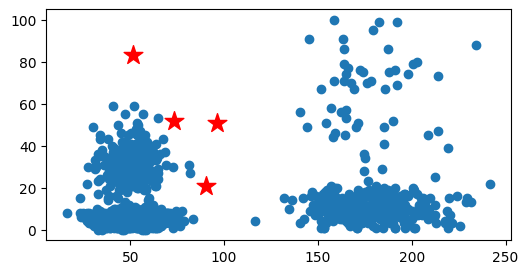

In [5]:
print('Los centros iniciales elegidos aleatoriamente son:')
K=4
cDx = paso1_elije_centros(K, Dx)
print(cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1])
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

2.   Paso de asignación de datos
En este paso, cada elemento de nuestro dataset se asigna al centroide más cercano basado en la distancia escogida: en nuestro caso, la Euclidiana. Por tanto, tendremos que implementar la siguiente operación:

$$
\DeclareMathOperator*{\argminA}{arg\,min}
\argminA_{c_i \in C} dist\left ( c_i, x \right )^2
$$

In [6]:
# Definimos la distancia euclidiana de una instancia x con respecto a un grupo de instancias C
def distancia_euclidiana_grupo(x, C):
  return np.linalg.norm(C - x, axis=1);

def paso2_asigna_puntos(Dx, cDx):
  Dyp = np.zeros(Dx.shape[0])
  # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
  for i in np.arange(Dx.shape[0]):
      # Tenemos que calcular la distancia de cada muestra del dataset Dx[i]
      # a cada centro existente en cDx. Podemos utilizar para ello la función
      # distancia_euclidiana_grupo.

      distancia_punto_a_centros = distancia_euclidiana_grupo(Dx[i],cDx ) # 1.2 Completa el codigo aqui

      # Una vez calculada la distancia, necesitamos averiguar el índice de
      # la distancia mínima. Para ello, podemos usar la función argmin de numpy.
      pred_y = np.argmin(distancia_punto_a_centros)
      Dyp[i] = pred_y
  return Dyp

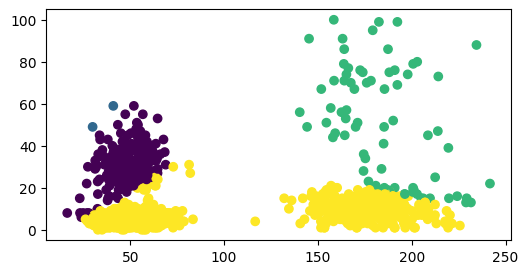

In [7]:
Dyp = paso2_asigna_puntos(Dx, cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

2.   Paso de actualización del centroide
En este paso se recalcula el centroide de cada cluster, teniendo en cuenta la nueva asignación calculada en el paso 1. Para ello, se calcula la media de todos los puntos asignados en el paso anterior.

$$
c_i = \frac{1}{\left | S_i \right |} \sum_{x_i \in S_i} x_i
$$


In [8]:
def paso3_actualiza_centros(Dx, cDx, Dyp, K):
  cDx_ant = cDx.copy()
  for k in range(K):
      # Seleccionamos los puntos asignados al cluster k
      puntos_cluster_k = Dx[Dyp == k]
      # Calculamos la media de las coordenadas x e y
      if len(puntos_cluster_k) > 0:  # Evitar división por cero si el cluster está vacío
          cDx[k,:] = np.mean(puntos_cluster_k, axis=0) # 1.3 Completa el codigo aqui
      else:
          # Si el cluster está vacío, mantenemos el centroide anterior
          cDx[k,:] = cDx_ant[k,:]
  return cDx

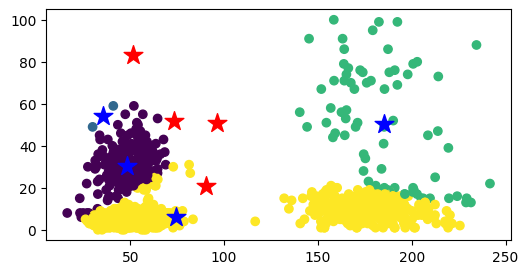

In [9]:
cDx_ant = cDx.copy()
cDx =paso3_actualiza_centros(Dx, cDx, Dyp, K)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='b')
ax.scatter(cDx_ant[:,0],cDx_ant[:,1], marker='*', s=200, c='r')

Y esto es todo. Este proceso se repite hasta cumplir un criterio de detención:

*   No hay cambios en los puntos asignados a cada cluster
*   La suma de las distancias alcanza un valor mínimo establecido
*   Se alcanza un número máximo de iteraciones

In [10]:
def MyKMeans(Dx, K):
  cDx = paso1_elije_centros(K, Dx) # 1.4 Completa el codigo aqui
  cDxIni = cDx.copy()
  # Flag de convergencia
  iterando = True
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    Dyp = paso2_asigna_puntos(Dx, cDx) # 1.5 Completa el codigo aqui
    # Calcular los nuevos centros
    #cDx = # 1.6 Completa el codigo aqui
    cDx =paso3_actualiza_centros(Dx, cDx, Dyp, K)
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)
  return cDx, Dyp, cDxIni

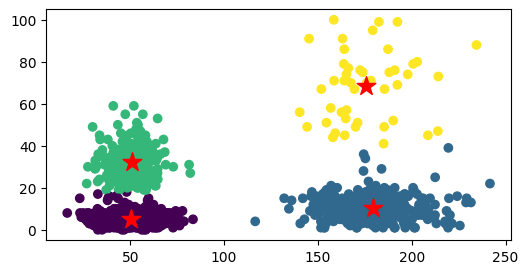

In [11]:
cDx, Dyp,cDxIni = MyKMeans(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

# 🎯 **EJ 1: MODIFICA KMEANS PARA QUE SE CONVIERTA EN KMEANS++**

In [14]:
def distancia_euclidiana(a, b):
  return np.sqrt(np.sum((a - b) ** 2, axis=1))

def paso1_elije_centros_inteligente(K, Dx):
  cDx = np.zeros(K*Dx.shape[1])
  cDx.shape = (K,Dx.shape[1])

  # Paso 1: Primer centroide aleatorio,se elige aleatoriamente
  #        un punto de datos como primer centroide.
  n_samples, n_features = Dx.shape
  first_idx = np.random.randint(n_samples)
  cDx[0] = Dx[first_idx]

  # Pasos 2-4: Elegir centroides restantes
  for k in range(1, K):
      # Calcular distancias al centroide más cercano
      distances = np.zeros(n_samples)
      for i in range(n_samples):
          # Distancias del punto i a todos los centroides existentes
          point = Dx[i]
          dist_to_centroids = distancia_euclidiana(
              cDx[:k],
              np.tile(point, (k, 1))
          )
          # Guardar la distancia mínima
          distances[i] = np.min(dist_to_centroids)
      # Convertir distancias a probabilidades
      probabilities = distances ** 2
      probabilities /= probabilities.sum()

      # Elegir siguiente centroide basado en probabilidades
      next_idx = np.random.choice(n_samples, p=probabilities)
      cDx[k] = Dx[next_idx]
  return cDx

In [16]:
def MyKMeansPlusPlus(Dx, K):
  cDx = paso1_elije_centros_inteligente(K, Dx)
  cDxIni = cDx.copy()
  # Flag de convergencia
  iterando = True
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    Dyp = paso2_asigna_puntos(Dx, cDx)
    # Calcular los nuevos centros
    cDx = paso3_actualiza_centros(Dx, cDx, Dyp, K) # 1.5 Completa tu código aquí
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)
  return cDx, Dyp, cDxIni

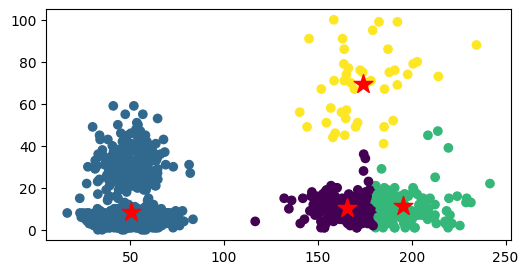

In [17]:
cDx, Dyp,cDxIni = MyKMeansPlusPlus(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

# 🎯 **EJ 2: USA EL METODO DEL CODO CON KMEANS++ PARA DETERMINAR EL MEJOR K**
<hr>
<h2>Elegir el mejor valor de K</h2>

Para elegir el mejor valor de K se suele usar la técnica del codo. Ésta consiste en probar diferentes valores de K y evaluar el agrupamientos según alguna medida de evaluación intrínseca (ya que se supone que no se conoce la verdad básica). En este ejemplo, se usan dos medidas diferentes: la medida de Silueta y la R cuadrado.


In [18]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [19]:
def medida_R_cuadrado(X, Xyp, cXs):
    # Calcular SST (Suma Total de Cuadrados)
    centro_global = np.mean(X, axis=0)
    SST = np.sum(np.sum((X - centro_global)**2, axis=1))
    # Calcular SSE (Suma de Cuadrados del Error)
    SSE = 0
    for i in range(len(X)):
        # Encontrar el centroide correspondiente para cada punto
        cluster_label = int(Xyp[i])
        centroide = cXs[cluster_label]
        SSE += np.sum((X[i] - centroide)**2)

    # Calcular R²
    if SST == 0:
        return 1.0
    R_cuadrado = 1 - (SSE / SST)
    return R_cuadrado

Text(0, 0.5, 'Medida de R cuadrado')

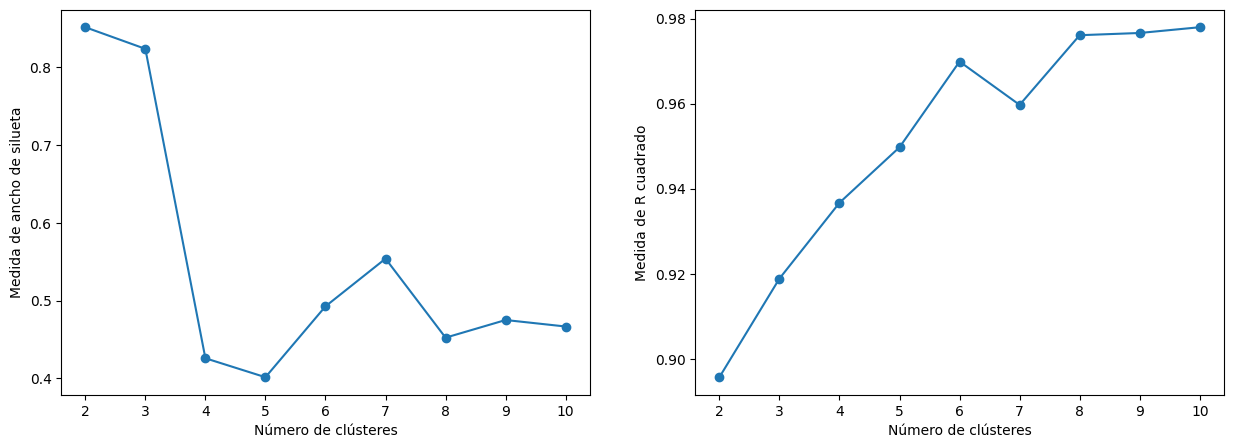

In [21]:
#METODO DEL CODO
# voy a probar para valores de k desde 2 al 11
rsilueta = np.zeros(9)
rrsquare = np.zeros(9)
for k in np.arange(2,11):
    cDx, Dyp,cDxIni = MyKMeansPlusPlus(Dx, k)
    rsilueta[k-2] = silhouette_score(Dx, Dyp) # 2.1 Completa el codigo aqui
    rrsquare[k-2] = medida_R_cuadrado(Dx, Dyp, cDx) # 2.2 Completa el codigo aqui

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot( np.arange(2,11),rsilueta, linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de ancho de silueta")

ax[1].plot( np.arange(2,11),rrsquare, linestyle='-', marker='o')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Medida de R cuadrado")

Redacte una conclusión que analice los gráficos del método del codo y del coeficiente de silueta (y/o R²) para la selección del número de clusters (k). Indique cuál es el valor óptimo de k y fundamente su elección con base en la interpretación de dichos gráficos.

## Métricas disponibles en KMeans de scikit-learn
El objeto KMeans de scikit-learn proporciona varias métricas y atributos importantes para evaluar el clustering:


Text(0, 0.5, 'Índice de Calinski-Harabasz')

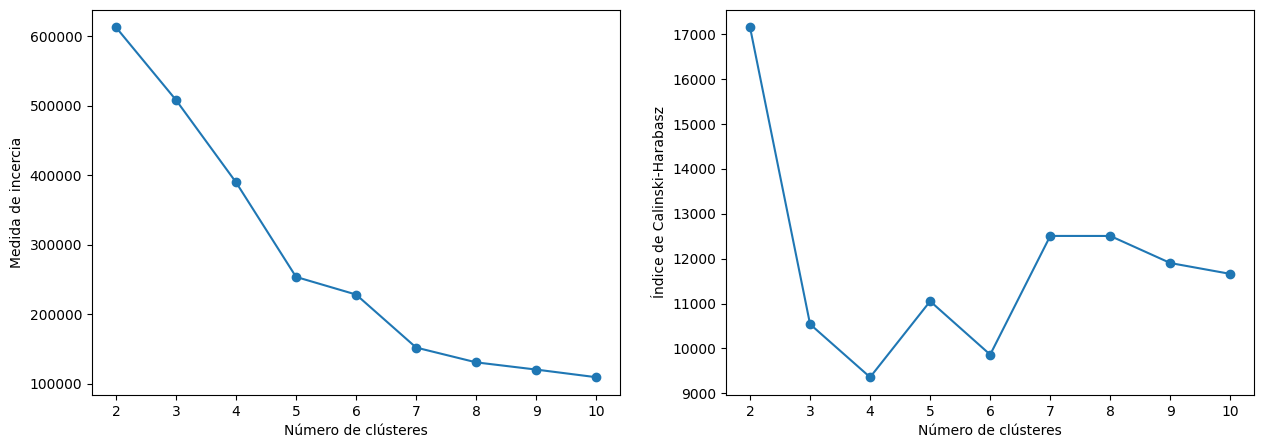

In [23]:
from sklearn.cluster import KMeans

rincercia = np.zeros(9)
rcalinski = np.zeros(9)
for k in np.arange(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(Dx)
    rincercia[k-2] =  kmeans.inertia_
    rcalinski[k-2] = calinski_harabasz_score(Dx, kmeans.labels_)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot( np.arange(2,11),rincercia, linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de incercia")

ax[1].plot(np.arange(2,11), rcalinski, linestyle='-', marker='o')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Índice de Calinski-Harabasz")

In [ ]:
# The code for plotting the Calinski-Harabasz index has been integrated into the previous cell (3sdaSSAYVKTb).

Redacte una conclusión comparativa basada en el gráfico de inercia (método del codo) y el índice de Calinski-Harabasz. Determine el número óptimo de clusters (k) e interprete cómo cada métrica justifica dicha selección.

**Comparativa basada en el gráfico de inercia (método del codo) y el índice de Calinski-Harabasz**

1.  **Inercia (Método del Codo):**
    *   El gráfico de inercia muestra una disminución pronunciada en el valor de la inercia a medida que `k` aumenta desde k = 2, pero en k = 4, la tasa de disminución comienza a ralentizarse significativamente. Esto sugiere que añadir más de 4 clusters no proporciona una mejora sustancial en la reducción de la suma de cuadrados dentro de los clusters, haciendo de k=4 un fuerte candidato.

2.  **Índice de Calinski-Harabasz:**
    *   El índice de Calinski-Harabasz también alcanza su valor máximo en **k=2**, lo que refuerza la idea de que dos clusters ofrecen la mejor combinación de densidad y separación. Este índice favorece la partición en 2 clusters como la más óptima en términos de la relación entre la dispersión inter-cluster y la intra-cluster.

**Número óptimo de clusters**

Existe una discrepancia clara entre las métricas. El **Coeficiente de Silueta** y el **Índice de Calinski-Harabasz** sugieren fuertemente **k=2** como el número óptimo, indicando una partición con la mejor separación y densidad de clusters. Por otro lado, el **Método del Codo (Inercia)** apunta a **k=4** como el punto donde los rendimientos decrecientes comienzan a aparecer. El **R Cuadrado** muestra una buena explicación de la varianza para k=4, con ganancias marginales a partir de k=5.

Basándonos en la convergencia del Método del Codo y el alto R Cuadrado, junto con la posible estructura del dataset, el número óptimo de clusters se establece en **k=4**. Buscando así un equilibrio entre la interpretabilidad y la reducción de la varianza, permitiendo una visión más detallada de las posibles cuatro densidades.

**Análisis de las Métricas:**
- Inercia (Método del Codo): La inercia mide la suma de las distancias al cuadrado de cada punto a su centroide más cercano.En nuestro caso, observamos que la inercia disminuye significativamente hasta k=4, y luego la reducción es menos pronunciada. Un posible codo se podría identificar alrededor de k=4 o k=5.

- Coeficiente de Silueta: Este coeficiente mide qué tan similar es un objeto a su propio clúster (cohesión) en comparación con otros clústeres (separación). Los valores más cercanos a 1 indican una buena agrupación. El gráfico de silueta muestra un pico inicial en k=2 (0.85), seguido de un valor alto en k=3 (0.82) y luego una caída para k=4 (0.42). Esto sugiere que k=2 o k=3 podrían ser buenos candidatos.

- R Cuadrado (R²): Un R² más alto indica que los clústeres explican mejor la varianza total de los datos. Observamos que el R² aumenta constantemente y alcanza valores altos para k=5 (0.969) y k=7 (0.976), sugiriendo que un mayor número de clusters podría explicar mejor los datos, aunque la mejora marginal disminuye.

- Índice de Calinski-Harabasz: Es la relación entre la dispersión inter-clúster y la dispersión intra-clúster. Un valor más alto generalmente indica clústeres más densos y mejor separados. El gráfico muestra que el índice es alto para k=2 (17148) y k=3 (10541). Después de k=3, hay una caída y luego un repunte en k=7 (12503). Esto sugiere que k=2 o k=7 podrían ser óptimos.

# 🎯 **EJ 3: USA EL SIGUIENTE DATASET CON KMEANS++**
Cargue el dataset dataset_cuatro_separables_peque y realice el siguiente análisis de agrupamiento (clustering):

Determinación del k óptimo: Utilice el algoritmo k-means para calcular y graficar el método del codo con un rango de k razonable (por ejemplo, de 2 a 15 clusters).

Selección: Con base en los gráficos, justifique y seleccione el número óptimo de clusters (k_optimo).

Modelo final: Ajuste un modelo final de k-means utilizando el k_optimo.

Visualización: Visualice los resultados del agrupamiento y que los puntos estén coloreados según el cluster asignado. Incluya los centroides en la visualización.

✅ Dataset cargado desde URL GitHub


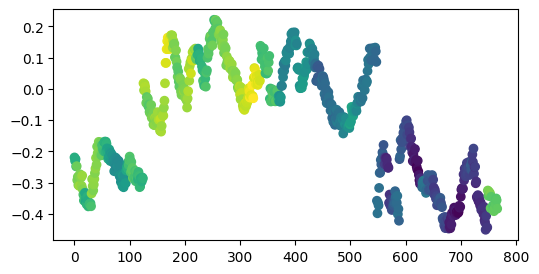

In [52]:
# Cargar dataset
D =cargar_dataset("dataset_cuatro_separables_peque.xlsx")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

In [53]:
# PASO 1 elejir los centros iniciales de forma randomica
def random_sample_float(n, mi, ma):
    return (ma - mi) * np.random.random_sample(n) + mi

def paso1_elije_centros(K, Dx):
  cDx = np.zeros(K*Dx.shape[1])
  cDx.shape = (K,Dx.shape[1])
  # 1.1 Completa el codigo aqui
  x1 = random_sample_float(K, np.min(Dx[:,0]), np.max(Dx[:,0]))
  x2 = random_sample_float(K, np.min(Dx[:,1]), np.max(Dx[:,1]))
  cDx[:,0] = x1
  cDx[:,1] = x2
  return cDx


Los centros iniciales elegidos aleatoriamente son:
[[ 5.17998945e+02 -3.92294551e-02]
 [ 1.58058304e+01 -2.43732820e-01]
 [ 6.90968483e+02 -3.80137956e-01]
 [ 5.54697128e+02 -4.04437542e-01]]


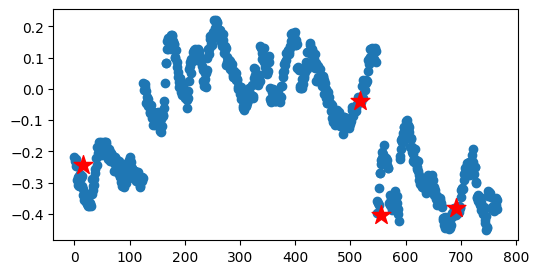

In [54]:
print('Los centros iniciales elegidos aleatoriamente son:')
K=4
cDx = paso1_elije_centros(K, Dx)
print(cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1])
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

In [55]:
# Definimos la distancia euclidiana de una instancia x con respecto a un grupo de instancias C
def distancia_euclidiana_grupo(x, C):
  return np.linalg.norm(C - x, axis=1);

def paso2_asigna_puntos(Dx, cDx):
  Dyp = np.zeros(Dx.shape[0])
  # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
  for i in np.arange(Dx.shape[0]):
      # Tenemos que calcular la distancia de cada muestra del dataset Dx[i]
      # a cada centro existente en cDx. Podemos utilizar para ello la función
      # distancia_euclidiana_grupo.

      distancia_punto_a_centros = distancia_euclidiana_grupo(Dx[i],cDx ) # 1.2 Completa el codigo aqui

      # Una vez calculada la distancia, necesitamos averiguar el índice de
      # la distancia mínima. Para ello, podemos usar la función argmin de numpy.
      pred_y = np.argmin(distancia_punto_a_centros)
      Dyp[i] = pred_y
  return Dyp

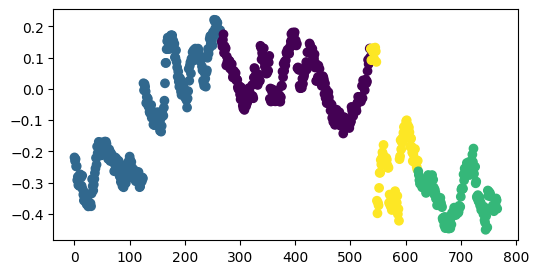

In [56]:
Dyp = paso2_asigna_puntos(Dx, cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

In [57]:
def paso3_actualiza_centros(Dx, cDx, Dyp, K):
  cDx_ant = cDx.copy()
  for k in range(K):
      # Seleccionamos los puntos asignados al cluster k
      puntos_cluster_k = Dx[Dyp == k]
      # Calculamos la media de las coordenadas x e y
      if len(puntos_cluster_k) > 0:  # Evitar división por cero si el cluster está vacío
          cDx[k,:] = np.mean(puntos_cluster_k, axis=0) # 1.3 Completa el codigo aqui
      else:
          # Si el cluster está vacío, mantenemos el centroide anterior
          cDx[k,:] = cDx_ant[k,:]
  return cDx

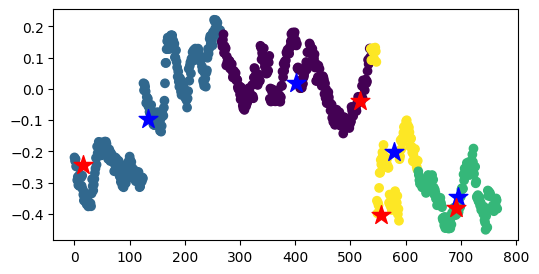

In [58]:
cDx_ant = cDx.copy()
cDx =paso3_actualiza_centros(Dx, cDx, Dyp, K)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='b')
ax.scatter(cDx_ant[:,0],cDx_ant[:,1], marker='*', s=200, c='r')

In [59]:
def MyKMeans(Dx, K):
  cDx = paso1_elije_centros(K, Dx) # 1.4 Completa el codigo aqui
  cDxIni = cDx.copy()
  # Flag de convergencia
  iterando = True
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    Dyp = paso2_asigna_puntos(Dx, cDx) # 1.5 Completa el codigo aqui
    # Calcular los nuevos centros
    #cDx = # 1.6 Completa el codigo aqui
    cDx =paso3_actualiza_centros(Dx, cDx, Dyp, K)
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)
  return cDx, Dyp, cDxIni

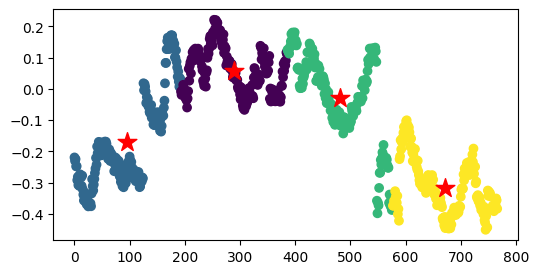

In [60]:
cDx, Dyp,cDxIni = MyKMeans(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

In [61]:
def distancia_euclidiana(a, b):
  return np.sqrt(np.sum((a - b) ** 2, axis=1))

def paso1_elije_centros_inteligente(K, Dx):
  cDx = np.zeros(K*Dx.shape[1])
  cDx.shape = (K,Dx.shape[1])

  # Paso 1: Primer centroide aleatorio,se elige aleatoriamente
  #        un punto de datos como primer centroide.
  n_samples, n_features = Dx.shape
  first_idx = np.random.randint(n_samples)
  cDx[0] = Dx[first_idx]

  # Pasos 2-4: Elegir centroides restantes
  for k in range(1, K):
      # Calcular distancias al centroide más cercano
      distances = np.zeros(n_samples)
      for i in range(n_samples):
          # Distancias del punto i a todos los centroides existentes
          point = Dx[i]
          dist_to_centroids = distancia_euclidiana(
              cDx[:k],
              np.tile(point, (k, 1))
          )
          # Guardar la distancia mínima
          distances[i] = np.min(dist_to_centroids)
      # Convertir distancias a probabilidades
      probabilities = distances ** 2
      probabilities /= probabilities.sum()

      # Elegir siguiente centroide basado en probabilidades
      next_idx = np.random.choice(n_samples, p=probabilities)
      cDx[k] = Dx[next_idx]
  return cDx

In [62]:
def MyKMeansPlusPlus(Dx, K):
  cDx = paso1_elije_centros_inteligente(K, Dx)
  cDxIni = cDx.copy()
  # Flag de convergencia
  iterando = True
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    Dyp = paso2_asigna_puntos(Dx, cDx)
    # Calcular los nuevos centros
    cDx = paso3_actualiza_centros(Dx, cDx, Dyp, K) # 1.5 Completa tu código aquí
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)
  return cDx, Dyp, cDxIni

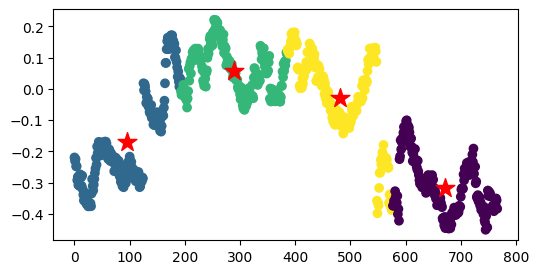

In [63]:
cDx, Dyp,cDxIni = MyKMeansPlusPlus(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

In [64]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

def medida_R_cuadrado(X, Xyp, cXs):
    # Calcular SST (Suma Total de Cuadrados)
    centro_global = np.mean(X, axis=0)
    SST = np.sum(np.sum((X - centro_global)**2, axis=1))
    # Calcular SSE (Suma de Cuadrados del Error)
    SSE = 0
    for i in range(len(X)):
        # Encontrar el centroide correspondiente para cada punto
        cluster_label = int(Xyp[i])
        centroide = cXs[cluster_label]
        SSE += np.sum((X[i] - centroide)**2)

    # Calcular R²
    if SST == 0:
        return 1.0
    R_cuadrado = 1 - (SSE / SST)
    return R_cuadrado

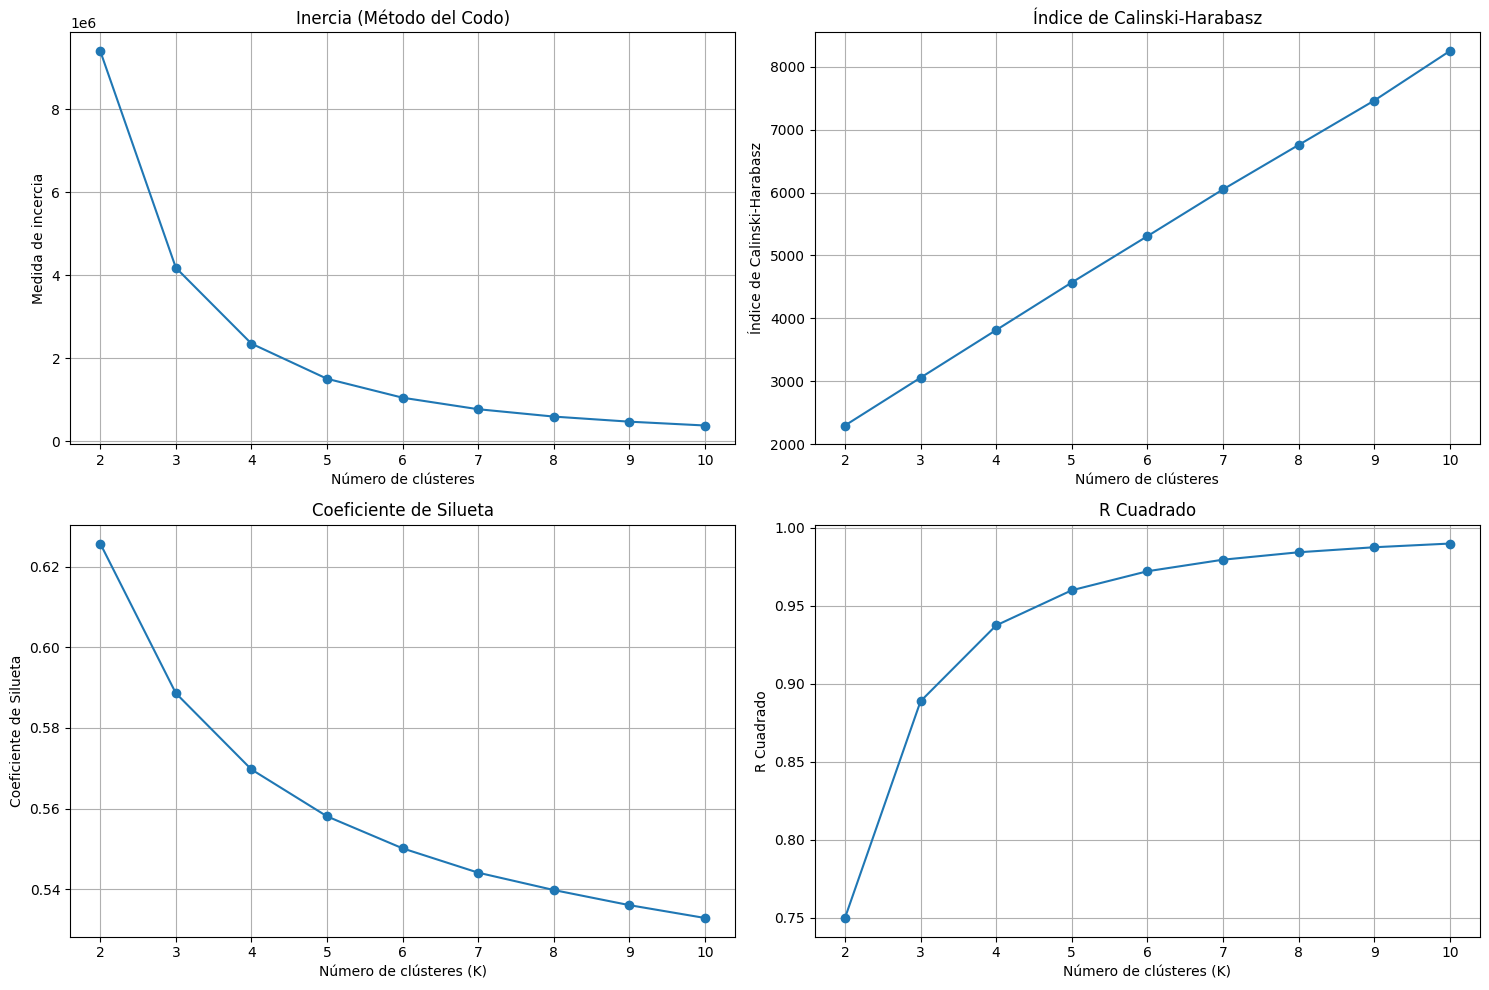

In [65]:
from sklearn.cluster import KMeans

rincercia = np.zeros(9)
rcalinski = np.zeros(9)
for k in np.arange(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(Dx)
    rincercia[k-2] =  kmeans.inertia_
    rcalinski[k-2] = calinski_harabasz_score(Dx, kmeans.labels_)

fig, ax = plt.subplots(2, 2, figsize=(15,10))

ax[0,0].plot( np.arange(2,11),rincercia, linestyle='-', marker='o')
ax[0,0].set_xlabel("Número de clústeres")
ax[0,0].set_ylabel("Medida de incercia")
ax[0,0].set_title("Inercia (Método del Codo)")
ax[0,0].grid(True)

ax[0,1].plot(np.arange(2,11), rcalinski, linestyle='-', marker='o')
ax[0,1].set_xlabel("Número de clústeres")
ax[0,1].set_ylabel("Índice de Calinski-Harabasz")
ax[0,1].set_title("Índice de Calinski-Harabasz")
ax[0,1].grid(True)

ax[1,0].plot(np.arange(2,11), rsilueta, linestyle='-', marker='o')
ax[1,0].set_xlabel("Número de clústeres (K)")
ax[1,0].set_ylabel("Coeficiente de Silueta")
ax[1,0].set_title("Coeficiente de Silueta")
ax[1,0].grid(True)

ax[1,1].plot(np.arange(2,11), rrsquare, linestyle='-', marker='o')
ax[1,1].set_xlabel("Número de clústeres (K)")
ax[1,1].set_ylabel("R Cuadrado")
ax[1,1].set_title("R Cuadrado")
ax[1,1].grid(True)

plt.tight_layout()
plt.show()

**Comparativa basada en el gráfico de inercia (método del codo) y el índice de Calinski-Harabasz**

1.  **Inercia (Método del Codo):**
    *   El gráfico de inercia muestra una disminución pronunciada en el valor de la inercia a medida que `k` aumenta desde k = 2, pero en k = 4, la tasa de disminución comienza a ralentizarse significativamente. Esto sugiere que añadir más de 4 clusters no proporciona una mejora sustancial en la reducción de la suma de cuadrados dentro de los clusters, haciendo de k=4 un fuerte candidato.

2.  **Índice de Calinski-Harabasz:**
    *   El índice de Calinski-Harabasz también alcanza su valor máximo en **k=2**, lo que refuerza la idea de que dos clusters ofrecen la mejor combinación de densidad y separación. Este índice favorece la partición en 2 clusters como la más óptima en términos de la relación entre la dispersión inter-cluster y la intra-cluster.

**Número óptimo de clusters**

Existe una discrepancia clara entre las métricas. El **Coeficiente de Silueta** y el **Índice de Calinski-Harabasz** sugieren fuertemente **k=2** como el número óptimo, indicando una partición con la mejor separación y densidad de clusters. Por otro lado, el **Método del Codo (Inercia)** apunta a **k=4** como el punto donde los rendimientos decrecientes comienzan a aparecer. El **R Cuadrado** muestra una buena explicación de la varianza para k=4, con ganancias marginales a partir de k=5.

Basándonos en la convergencia del Método del Codo y el alto R Cuadrado, junto con la posible estructura del dataset, el número óptimo de clusters se establece en **k=4**. Buscando así un equilibrio entre la interpretabilidad y la reducción de la varianza, permitiendo una visión más detallada de las posibles cuatro densidades.

In [66]:
k_optimo = 4
cDx_final, Dyp_final, _ = MyKMeansPlusPlus(Dx, k_optimo)
print(f"Modelo K-Means++ ajustado con k_optimo = {k_optimo}")
print("Centroides Finales (cDx_final):")
print(cDx_final)

Modelo K-Means++ ajustado con k_optimo = 4
Centroides Finales (cDx_final):
[[ 9.45000000e+01 -1.72582424e-01]
 [ 4.76500000e+02 -1.88486605e-02]
 [ 6.69500000e+02 -3.16562995e-01]
 [ 2.85000000e+02  5.44475804e-02]]


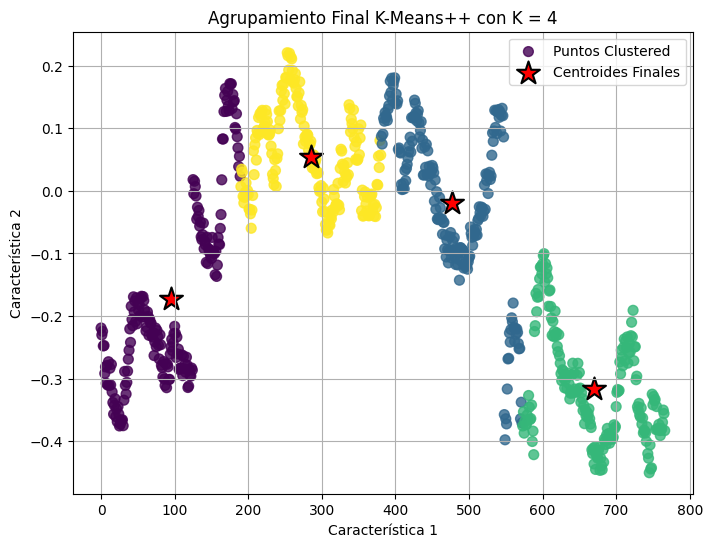

In [70]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(Dx[:, 0], Dx[:, 1], c=Dyp_final, cmap='viridis', s=50, alpha=0.8, label='Puntos Clustered')
ax.scatter(cDx_final[:, 0], cDx_final[:, 1], marker='*', s=300, c='red', edgecolor='black', linewidth=1.5, label='Centroides Finales')
ax.set_title(f"Agrupamiento Final K-Means++ con K = {k_optimo}")
ax.set_xlabel("Característica 1")
ax.set_ylabel("Característica 2")
ax.legend()
ax.grid(True)
plt.show()

# 🚀 ¡TALLER FINALIZADO!"